In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [31]:
def gower_distance(X,forced_column_type_assignment=None):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []
    if forced_column_type_assignment==None:
        for i in range(X.shape[1]):
            feature = X.iloc[:,[i]]
            if feature.dtypes[0] == np.object:
                feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
            else:
                feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)
    
            individual_variable_distances.append(feature_dist)
    else:
        for feature in list(X.columns.values):
            if forced_column_type_assignment[feature] == 'nominal':
                feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
            elif forced_column_type_assignment[feature] == 'numeric':
                feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)
            else:
                print("This implimentation of Gowers distance only supports numeric and nominal feature types currently.")
                return
            individual_variable_distances.append(feature_dist)
        
        
        list(df.columns.values)
    return np.array(individual_variable_distances).mean(0)

In [32]:
df=pd.read_csv("/Users/deaxman/Projects/DATA/General/titanic.csv")

df=df.drop(['name', 'cabin','ticket'], axis=1).dropna(axis=0,how='any')  


gamma=0.1
forced_column_type_assignment={'survived':'nominal',
                               'pclass':'nominal',
                               'sex':'nominal',
                               'age':'numeric',
                               'sibsp':'numeric',
                               'parch':'numeric',
                               'fare':'numeric',
                               'embarked':'nominal'}

In [33]:
for feature in list(df.columns.values):
    if forced_column_type_assignment[feature]=='numeric':
        x = df[feature].values #returns a numpy array
        x_scaled = (x-np.mean(x))/(np.max(x)-np.min(x))
        df[feature] = pd.Series(x_scaled,index=df.index)

In [34]:
dist_mat=gower_distance(df)
affinity_mat=np.exp(-gamma * dist_mat ** 2)

In [35]:
labelingOptions=[]
labelNames=[]
for i in range(2,9):
    spectral_clust=SpectralClustering(n_clusters=i,affinity='precomputed')
    agglomerative_clust_1=AgglomerativeClustering(n_clusters=i,affinity='precomputed',linkage='complete')
    agglomerative_clust_2=AgglomerativeClustering(n_clusters=i,affinity='precomputed',linkage='average')
    #DBSCAN_clust=DBSCAN(eps=.15189,metric='precomputed')
    spectral_clust.fit(affinity_mat)
    agglomerative_clust_1.fit(dist_mat)
    agglomerative_clust_2.fit(dist_mat)
    #DBSCAN_clust.fit(dist_mat)
    labelNames.append('Num clust: {0}, Type: Spectral'.format(i))
    labelingOptions.append(spectral_clust.labels_)
    labelNames.append('Num clust: {0}, Type: Agglomerative (complete linkage)'.format(i))
    labelingOptions.append(agglomerative_clust_1.labels_)
    labelNames.append('Num clust: {0}, Type: Agglomerative (average linkage)'.format(i))
    labelingOptions.append(agglomerative_clust_2.labels_)
    #labelingOptions.append(DBSCAN_clust.labels_)

In [36]:
full_df=pd.get_dummies(df)
X=full_df.values
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



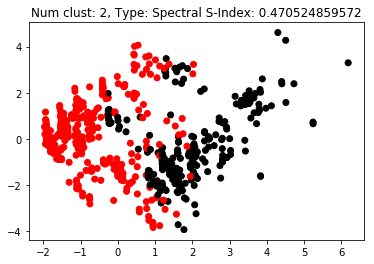

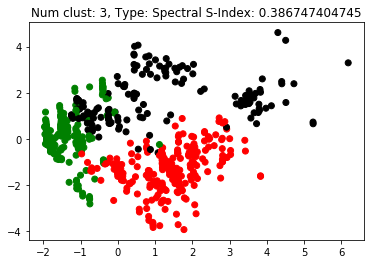

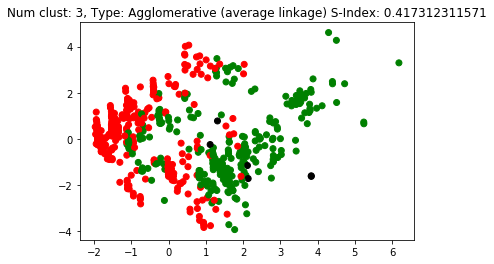

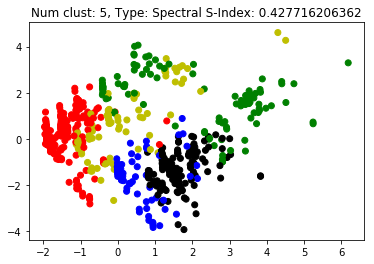

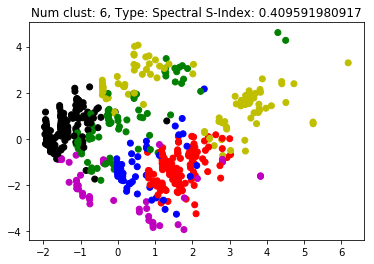

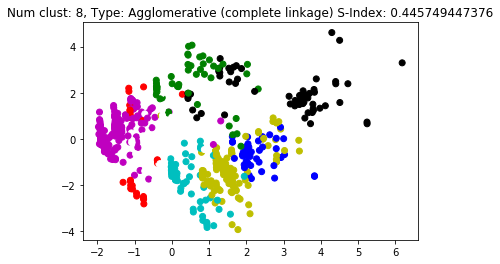

In [37]:
plt.close("all")
LABEL_COLOR_MAP = {0 : 'r',
                       1 : 'k',
                       2 : 'g',
                       3 : 'y',
                       4 : 'b',
                       5 : 'm',
                       6 : 'c',
                       7 : 'w',
                       }

x1=principalDf['principal component 1'].values
x2=principalDf['principal component 2'].values
#labelingLists=[spectral_clust.labels_,agglomerative_clust_1.labels_,agglomerative_clust_2.labels_]
labelingLists=labelingOptions
silhouette_indices=[(silhouette_score(dist_mat,labels=labeling,metric="precomputed")) for labeling in labelingOptions]
thresh=np.sort(silhouette_indices)[-7]
for i,labeling in enumerate(labelingLists):
    if silhouette_indices[i]>thresh:
        plt.figure()
        plt.title((labelNames[i]+" S-Index: "+str(silhouette_indices[i])))
        label_color = [LABEL_COLOR_MAP[l] for l in labeling]
        plt.scatter(x1,x2 , c=label_color)